<a href="https://colab.research.google.com/github/evanstaffen/Medical-Transcript-Classification/blob/main/GloveVectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 60.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, make_scorer, \
f1_score, precision_score, recall_score, accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import gensim
import gensim.downloader as api
from gensim.models import KeyedVectors, Word2Vec
from gensim.utils import simple_preprocess

from keras.utils import pad_sequences
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import regularizers

import pickle

In [ ]:
with open('/content/drive/MyDrive/Medical Transcript Classification/Medical-Transcription-Classification copy/data/df.pickle', 'rb') as f:
    df = pickle.load(f)
df

,medical_specialty,transcription,transcript_gensim,gensim_cleaned
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...","[mode, leave, atrial, enlargement, leave, atri...","[mode, leave, atrial, enlargement, leave, atri..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,"[leave, ventricular, cavity, size, wall, thick...","[leave, ventricular, cavity, size, wall, thick..."
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","[echocardiogram, multiple, view, heart, great,...","[echocardiogram, multiple, view, heart, great,..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....","[description, normal, cardiac, chamber, size, ...","[description, normal, cardiac, chamber, size, ..."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...","[study, mild, aortic, stenosis, widely, calcif...","[study, mild, aortic, stenosis, widely, calcif..."
...,...,...,...,...
3709,Cardiovascular / Pulmonary,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...","[indication, chest, pain, type, test, adenosin...","[indication, chest, pain, type, test, adenosin..."
3710,Cardiovascular / Pulmonary,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...","[chief, complaint, chest, pain, history, prese...","[chief, complaint, chest, pain, history, prese..."
3711,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , The patient is a...","[history, present, illness, patient, year, old...","[history, present, illness, patient, year, old..."
3712,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-...","[history, present, illness, mr, abc, year, old...","[history, present, illness, mr, abc, year, old..."


In [ ]:
max_length = 0
lengths = []
for doc in df['gensim_cleaned']:
    lengths.append(len(doc))
    if len(doc) > max_length:
        max_length = len(doc)
max_length

1293

In [ ]:
dictionary = gensim.corpora.Dictionary(df['gensim_cleaned'])

In [ ]:
list(api.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [ ]:
#google_glove = api.load('word2vec-google-news-300')
#glove = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
path = '/content/drive/MyDrive/Medical Transcript Classification/Medical-Transcription-Classification copy/word2vec_pretrained_models/'

In [ ]:
#google_glove.save_word2vec_format(path+'google_glove.bin',binary=True)
#glove.save_word2vec_format(path+'glove100.bin',binary=True)

In [ ]:
#google_glove = KeyedVectors.load_word2vec_format(path+'google_glove.bin', binary=True)
glove = KeyedVectors.load_word2vec_format(path+'glove100.bin', binary=True)

In [ ]:
oov_words = []
for doc in df['gensim_cleaned']:
  for word in doc:
    if word not in glove:
      oov_words.append(word)

oov_words = list(set(oov_words))

print(f'{round(100*(len(oov_words)/len(dictionary)),2)}% missing words from overall dictionary')

25.02% missing words from overall dictionary


In [ ]:
oov_words = []
for doc in df['gensim_cleaned']:
  for word in doc:
    if word not in google_glove:
      oov_words.append(word)

oov_words = list(set(oov_words))
print(f'{round(100*(len(oov_words)/len(dictionary)),2)}% missing words from overall dictionary')

26.87% missing words from overall dictionary


In [ ]:
def glove_doc(doc):
    default_vec = np.zeros(glove.vector_size)
    vecs = []
    for word in doc:
        try:
          vec = glove.get_vector(word)
          vecs.append(vec)
        except KeyError:
          vecs.append(default_vec)
    if max_length - len(vecs) != 0:
      num_zeros = max_length - len(vecs)
      for num in range(0,num_zeros):
        vecs.append(default_vec)
    return np.stack(vecs)

In [ ]:
df['glove_vec'] = df['gensim_cleaned'].apply(glove_doc)

In [ ]:
df['glove_vec'][0]

array([[-0.58454001,  0.17820001,  0.21089   , ..., -0.44538999,
         0.69067001, -0.17003   ],
       [-0.34228   , -0.30965   ,  0.22581001, ...,  0.74322999,
         0.075211  ,  0.12424   ],
       [ 0.068819  , -0.80163002, -0.50686997, ..., -0.57224   ,
         0.052387  , -0.87562001],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
#path = '/content/drive/MyDrive/Medical Transcript Classification/Medical-Transcription-Classification copy/data/'
#with open(path+'df_vecd.pickle', 'wb') as f:
#    pickle.dump(df, f)

In [ ]:
path = '/content/drive/MyDrive/Medical Transcript Classification/Medical-Transcription-Classification copy/data/'
with open(path+'df_vecd.pickle', 'rb') as f:
    df = pickle.load(f)

# Train-test-split

In [ ]:
X = df['glove_vec']
y = df['medical_specialty']

X_train, X_testval, y_train, y_testval = train_test_split(
    X, y, test_size=0.3,random_state=42, stratify=y
    )

X_val, X_test, y_val, y_test = train_test_split(
    X_testval, y_testval, test_size=0.33, 
    random_state=42,stratify = y_testval
    )


In [ ]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape,'\n')

display('Train', np.unique(y_train,return_counts=True))
display('Validation', np.unique(y_val,return_counts=True))
display('Test', np.unique(y_test,return_counts=True))

(2599,) (2599,)
(747,) (747,)
(368,) (368,) 



'Train'

(array(['Cardiovascular / Pulmonary',
        'Consult - History and Phy. / General Medicine',
        'Gastroenterology', 'Neurology / Neurosurgery',
        'Obstetrics / Gynecology', 'Orthopedic', 'Radiology', 'Surgery',
        'Urology'], dtype=object),
 array([260, 542, 157, 222, 109, 248, 191, 761, 109]))

'Validation'

(array(['Cardiovascular / Pulmonary',
        'Consult - History and Phy. / General Medicine',
        'Gastroenterology', 'Neurology / Neurosurgery',
        'Obstetrics / Gynecology', 'Orthopedic', 'Radiology', 'Surgery',
        'Urology'], dtype=object),
 array([ 74, 156,  45,  64,  31,  72,  55, 219,  31]))

'Test'

(array(['Cardiovascular / Pulmonary',
        'Consult - History and Phy. / General Medicine',
        'Gastroenterology', 'Neurology / Neurosurgery',
        'Obstetrics / Gynecology', 'Orthopedic', 'Radiology', 'Surgery',
        'Urology'], dtype=object),
 array([ 37,  77,  22,  31,  15,  35,  27, 108,  16]))

In [ ]:
X_tr_stack = np.stack(X_train)
X_val_stack = np.stack(X_val)
X_te_stack = np.stack(X_test)

# LabelEncoder

In [ ]:
le = LabelEncoder()
le.fit(y_train)
train_labels_encoded = le.transform(y_train)
val_labels_encoded = le.transform(y_val)
test_labels_encoded = le.transform(y_test)
num_classes = len(le.classes_)
mapping = dict(zip(range(len(le.classes_)), le.classes_))

# Saving arrays

In [ ]:
#path = '/content/drive/MyDrive/Medical Transcript Classification/Medical-Transcription-Classification copy/arrays/'
#np.save(path+'train_stacked.npy',X_tr_stack)
#np.save(path+'val_stacked.npy',X_val_stack)
#np.save(path+'test_stacked.npy',X_te_stack)
#np.save(path+'train_labels.npy',train_labels_encoded)
#np.save(path+'val_labels.npy',val_labels_encoded)
#np.save(path+'test_labels.npy',test_labels_encoded)

# Loading Arrays

In [2]:
path = '/content/drive/MyDrive/Medical Transcript Classification/Medical-Transcription-Classification copy/arrays/'

X_tr_stack = np.load(path+'train_stacked.npy')
X_val_stack = np.load(path+'val_stacked.npy')
X_te_stack = np.load(path+'test_stacked.npy')
train_labels_encoded = np.load(path+'train_labels.npy')
val_labels_encoded = np.load(path+'val_labels.npy')
test_labels_encoded = np.load(path+'test_labels.npy')


# Functions

In [3]:
def evaluate_model(model):
  predictions = model.predict(X_te_stack)
  predicted_max = np.argmax(predictions, axis=1)

  #predicted_labels = le.inverse_transform(predicted_max)
  #test_labels_decoded = le.inverse_transform(test_labels_encoded)

  acc_te = accuracy_score(test_labels_encoded,predicted_max)
  precision_te,recall_te,f1_te,_ = precision_recall_fscore_support(test_labels_encoded,
                                  predicted_max,average='weighted',zero_division = 0)
  print('Test Accuracy: ', acc_te)
  print('Test Precision: ', precision_te)
  print('Test Recall: ', recall_te)
  print('Test F1: ', f1_te)
  mapping = ['Cardiovascular / Pulmonary', 'Consult - History and Phy. / General Medicine', 'Gastroenterology',
'Neurology / Neurosurgery', 'Obstetrics / Gynecology', 'Orthopedic', 'Radiology', 
'Surgery', 'Urology']
  conf_matrix = confusion_matrix(test_labels_encoded,predicted_max)
  sns.heatmap(conf_matrix,annot=True,fmt='d',
              xticklabels=mapping,
              yticklabels=mapping
  );

In [4]:
def plot_history(results):
  history = results.history
  plt.figure() 
  plt.plot(history['val_loss']) 
  plt.plot(history['loss']) 
  plt.legend(['val_loss', 'loss']) 
  plt.title('Loss') 
  plt.xlabel('Epochs') 
  plt.ylabel('Loss')
  plt.show()

  plt.figure()
  plt.plot(history['val_accuracy'])
  plt.plot(history['accuracy'])
  plt.legend(['val_accuracy', 'accuracy'])
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

In [5]:
max_length = 1293
vec_size = 100

# First Model

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(max_length, vec_size), dropout=0.2, 
               recurrent_dropout=0.2,return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2,
               activation='relu'))
model.add(Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max',
                               restore_best_weights=True, min_delta=1e-4)

In [ ]:
results = model.fit(X_tr_stack, pd.get_dummies(train_labels_encoded), 
                    epochs=25, batch_size=128, 
          validation_data=[X_val_stack,pd.get_dummies(val_labels_encoded)],
          callbacks=[early_stopping]
          )


Epoch 1/25
21/21 [==============================] - 404s 19s/step - loss: nan - accuracy: 0.2366 - val_loss: nan - val_accuracy: 0.0991
Epoch 2/25
21/21 [==============================] - 387s 19s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0991
Epoch 3/25
21/21 [==============================] - 374s 18s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0991
Epoch 4/25
21/21 [==============================] - 383s 18s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0991
Epoch 5/25
21/21 [==============================] - 384s 18s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0991
Epoch 6/25
21/21 [==============================] - 372s 18s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0991


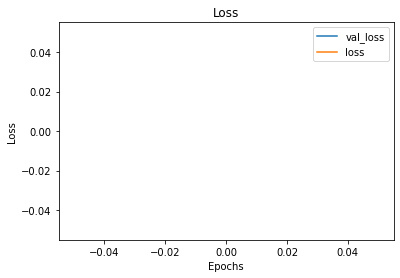

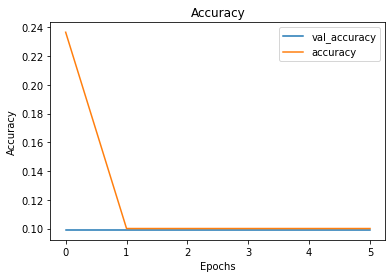

In [ ]:
plot_history(results)

12/12 [==============================] - 9s 735ms/step
Test Accuracy:  0.10054347826086957
Test Precision:  0.010108991020793951
Test Recall:  0.10054347826086957
Test F1:  0.01837090713902308


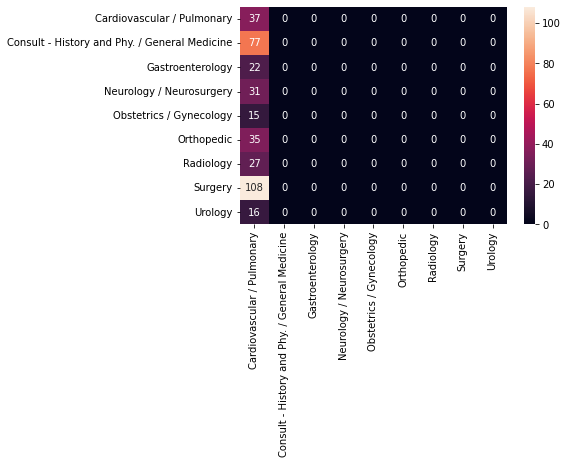

In [ ]:
evaluate_model(model)

# Second Model

### Adding another layer and changing activation function to tanh

In [6]:
model_2 = Sequential()
model_2.add(LSTM(128, input_shape=(max_length, vec_size), dropout=0.2, 
               recurrent_dropout=0.2,return_sequences=True,
               activation='tanh'))
model_2.add(Dropout(0.2))
model_2.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2,
               activation='tanh'))
model_2.add(Dense(9, activation='softmax'))

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max',
                               restore_best_weights=True, min_delta=1e-4)

In [7]:
results_2 = model_2.fit(X_tr_stack, pd.get_dummies(train_labels_encoded), 
                    epochs=25, batch_size=128, 
          validation_data=[X_val_stack,pd.get_dummies(val_labels_encoded)],
          callbacks=[early_stopping]
          )


Epoch 1/25
21/21 [==============================] - 512s 23s/step - loss: 2.0720 - accuracy: 0.2447 - val_loss: 1.9803 - val_accuracy: 0.2932
Epoch 2/25
21/21 [==============================] - 420s 20s/step - loss: 1.9834 - accuracy: 0.2928 - val_loss: 1.9782 - val_accuracy: 0.2932
Epoch 3/25
21/21 [==============================] - 402s 19s/step - loss: 1.9833 - accuracy: 0.2932 - val_loss: 1.9804 - val_accuracy: 0.2932
Epoch 4/25
21/21 [==============================] - 387s 18s/step - loss: 1.9837 - accuracy: 0.2932 - val_loss: 1.9796 - val_accuracy: 0.2932
Epoch 5/25
21/21 [==============================] - 386s 18s/step - loss: 1.9822 - accuracy: 0.2932 - val_loss: 1.9779 - val_accuracy: 0.2932
Epoch 6/25
21/21 [==============================] - 383s 18s/step - loss: 1.9840 - accuracy: 0.2932 - val_loss: 1.9818 - val_accuracy: 0.2932


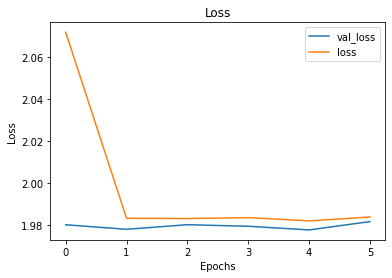

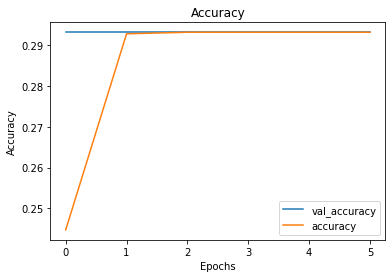

In [8]:
plot_history(results_2)

12/12 [==============================] - 10s 776ms/step
Test Accuracy:  0.29347826086956524
Test Precision:  0.08612948960302458
Test Recall:  0.29347826086956524
Test F1:  0.13317500913408842


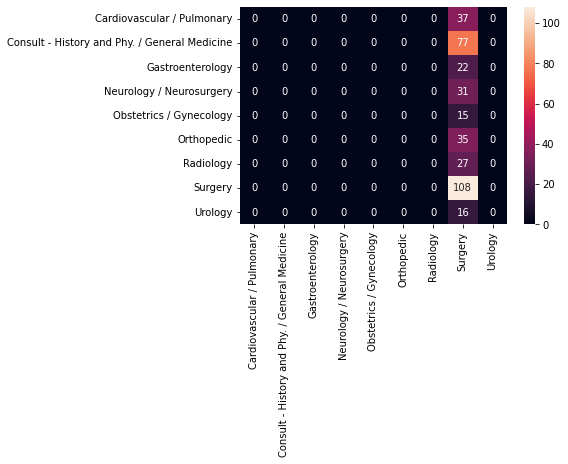

In [9]:
evaluate_model(model_2)

# Third Model

### Take out one layer and reducing nodes

In [8]:
model_3 = Sequential()
model_3.add(LSTM(64, input_shape=(max_length, vec_size), dropout=0.2, 
               recurrent_dropout=0.2, activation='tanh'))
model_3.add(Dense(9, activation='softmax'))

model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max',
                               restore_best_weights=True, min_delta=1e-4)

In [9]:
results_3 = model_3.fit(X_tr_stack, pd.get_dummies(train_labels_encoded), 
                    epochs=25, batch_size=128, 
          validation_data=[X_val_stack,pd.get_dummies(val_labels_encoded)],
          callbacks=[early_stopping]
          )


Epoch 1/25
21/21 [==============================] - 101s 5s/step - loss: 2.1147 - accuracy: 0.2813 - val_loss: 1.9981 - val_accuracy: 0.2932
Epoch 2/25
21/21 [==============================] - 92s 4s/step - loss: 1.9889 - accuracy: 0.2932 - val_loss: 1.9850 - val_accuracy: 0.2932
Epoch 3/25
21/21 [==============================] - 89s 4s/step - loss: 1.9823 - accuracy: 0.2932 - val_loss: 1.9775 - val_accuracy: 0.2932
Epoch 4/25
21/21 [==============================] - 88s 4s/step - loss: 1.9836 - accuracy: 0.2932 - val_loss: 1.9779 - val_accuracy: 0.2932
Epoch 5/25
21/21 [==============================] - 97s 5s/step - loss: 1.9822 - accuracy: 0.2932 - val_loss: 1.9786 - val_accuracy: 0.2932
Epoch 6/25
21/21 [==============================] - 91s 4s/step - loss: 1.9797 - accuracy: 0.2932 - val_loss: 1.9775 - val_accuracy: 0.2932


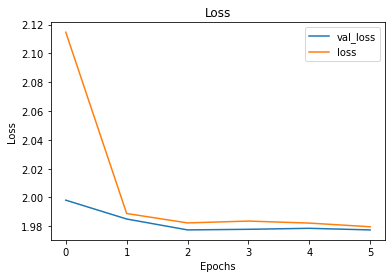

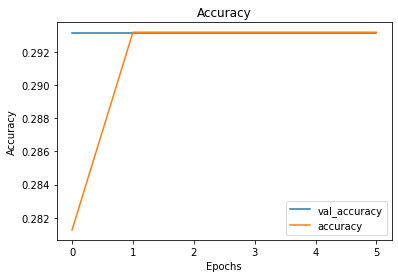

In [10]:
plot_history(results_3)

12/12 [==============================] - 5s 425ms/step
Test Accuracy:  0.29347826086956524
Test Precision:  0.08636417486079849
Test Recall:  0.29347826086956524
Test F1:  0.13345537757437073


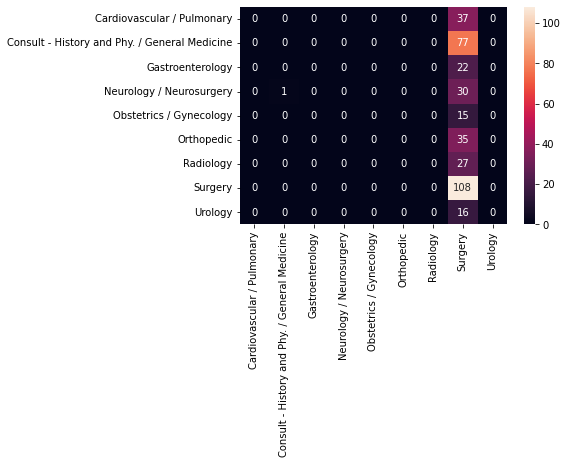

In [11]:
evaluate_model(model_3)

# Fourth Model

### Trying to add class-weights

In [6]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                                  classes = np.unique(train_labels_encoded), 
                                                  y = train_labels_encoded)
class_weights = dict(zip(np.unique(train_labels_encoded),class_weights))
class_weights

{0: 1.1106837606837607,
 1: 0.53280032800328,
 2: 1.8393489030431707,
 3: 1.3008008008008007,
 4: 2.6493374108053005,
 5: 1.164426523297491,
 6: 1.5119255381035486,
 7: 0.3794714556869616,
 8: 2.6493374108053005}

In [7]:
model_4 = Sequential()
model_4.add(LSTM(64, input_shape=(max_length, vec_size), dropout=0.2, 
               recurrent_dropout=0.2, activation='tanh'))
model_4.add(Dense(9, activation='softmax'))

model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max',
                               restore_best_weights=True, min_delta=1e-4)

In [8]:
results_4 = model_4.fit(X_tr_stack, pd.get_dummies(train_labels_encoded), 
                    epochs=25, batch_size=128, 
          validation_data=[X_val_stack,pd.get_dummies(val_labels_encoded)],
          callbacks=[early_stopping], class_weight=class_weights
          )


Epoch 1/25
21/21 [==============================] - 101s 5s/step - loss: 2.1977 - accuracy: 0.2597 - val_loss: 2.1956 - val_accuracy: 0.2932
Epoch 2/25
21/21 [==============================] - 89s 4s/step - loss: 2.1972 - accuracy: 0.1393 - val_loss: 2.1961 - val_accuracy: 0.0736
Epoch 3/25
21/21 [==============================] - 92s 4s/step - loss: 2.1971 - accuracy: 0.0766 - val_loss: 2.1976 - val_accuracy: 0.0415
Epoch 4/25
21/21 [==============================] - 91s 4s/step - loss: 2.1972 - accuracy: 0.0423 - val_loss: 2.1959 - val_accuracy: 0.0415
Epoch 5/25
21/21 [==============================] - 88s 4s/step - loss: 2.1972 - accuracy: 0.0581 - val_loss: 2.1976 - val_accuracy: 0.0736
Epoch 6/25
21/21 [==============================] - 100s 5s/step - loss: 2.1970 - accuracy: 0.0793 - val_loss: 2.1980 - val_accuracy: 0.0857


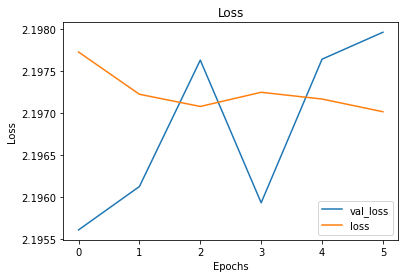

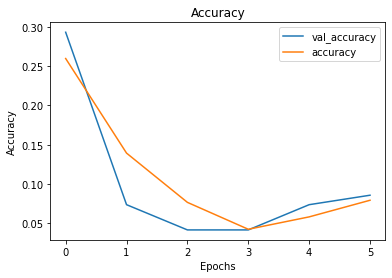

In [9]:
plot_history(results_4)

12/12 [==============================] - 5s 370ms/step
Test Accuracy:  0.29347826086956524
Test Precision:  0.08636417486079849
Test Recall:  0.29347826086956524
Test F1:  0.13345537757437073


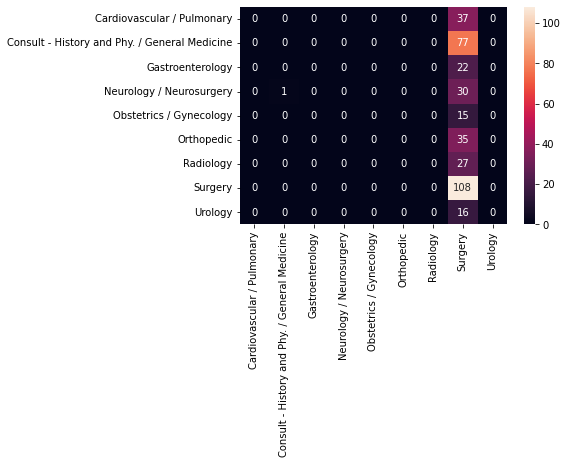

In [10]:
evaluate_model(model_4)